# Exercice I. Introduction to C-SVM

For illustrating kernel methods in general and for Support Vector Machines in particular, we consider a very simple classification problem. Let assume that the data is described in a 1D space divided into two classes ($+1$ and $-1$) as follows:

\begin{equation*}
\mathcal{S} = \{(\mathbf{x}_1 = 1, y_1 = 1), (\mathbf{x}_2 = 2, y_2 = 1), (\mathbf{x}_3 = 4, y_3 = -1), 
(\mathbf{x}_4 = 5, y_4 = -1), (\mathbf{x}_5 = 6, y_5 = 1)\}
\end{equation*}

The following script is used for visualizing the data.

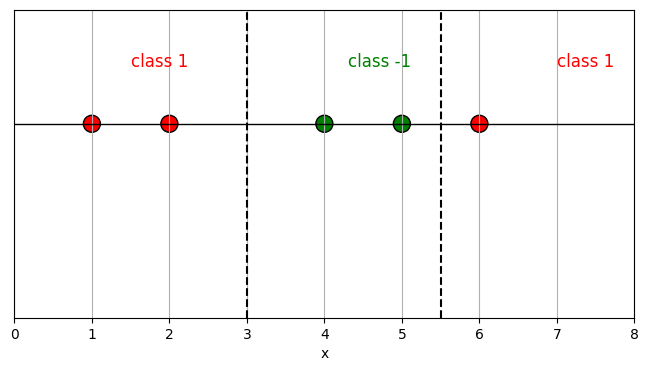

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
x = np.array([1, 2, 4, 5, 6])
class_labels = np.array([1, 1, 2, 2, 1])
y = class_labels - 3 + 3 *(class_labels == 1)

# Set up the plot
_, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x, np.zeros_like(x), 
            c=np.where(class_labels == 1, 'red', 'green'), 
            s=150, 
            edgecolors='black', 
            marker='o')

ax.set_ylim(-1.7, 1)
ax.set_xlim(0, 8)
ax.set_xlabel('x')
ax.set_yticks([])

# Add text annotations
ax.text(1.5, 0.5, 'class 1', color='red', fontsize=12)
ax.text(4.3, 0.5, 'class -1', color='green', fontsize=12)
ax.text(7, 0.5, 'class 1', color='red', fontsize=12)

# Add grid
ax.grid(True)

# Add horizontal and vertical lines
ax.axhline(0, color='black', linewidth=1)
ax.axvline(3, color='black', linestyle='--')
ax.axvline(5.5, color='black', linestyle='--')

# Show the plot
plt.show()

Of course, linear boundary can't discriminate the two classes and we propose 
to train a nonlinear SVM classifier combined with a second order polynomial 
kernel defined as: 

\begin{equation*}
k(\mathbf{x}_1, \mathbf{x}_2) = (\mathbf{x_1}^\top \mathbf{x}_2+1)^2. 
\end{equation*}

$\textbf{Question 1.}$ Write the dual formulation associated with the SVM optimization problem.

$$\mu^* = \max\limits_{\substack{0\leq\mu\leq C\\ \mu^Ty=0}}\mu^T\mathbf{1} - \frac{1}{2}\mu^T\text{diag}(y)K\text{diag}(y)\mu$$

Where:

$$ K = \begin{pmatrix} 4 & 9 & 25 & 36 & 49 \\
9 & 25 & 81 & 121 & 169 \\
25 & 81 & 289 & 441 & 625 \\
36 & 121 & 441 & 676 & 961 \\
49 & 169 & 625 & 961 & 1369
\end{pmatrix} $$

And:

$$ y = \begin{pmatrix} 1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{pmatrix} $$

$\textbf{Question 2.}$ Specify the arguments of the $\texttt{kernlab:::ipop}$ to solve this optimization problem.

In [14]:
# To use an equivalent of kernlab::ipop in python, we import cvxpy and we solve the problem using the library
import cvxpy as cp
C = 100

K = np.array([[(x[i]*x[j] + 1)**2 for i in range(x.shape[0])] for j in range(x.shape[0])])
H = np.diag(y) @ K @ np.diag(y) 
H = H - 1e-13 * np.eye(5) # Regularized term in case the solver has trouble with the non-negative approximation of one of the eigenvalues
c = np.ones((5,)) 

u = C * np.ones((5,))
# Defining and solving the CVXPY problem.
mu = cp.Variable(5)
prob = cp.Problem(cp.Maximize(c @ mu - 0.5*cp.quad_form(mu, H)),
                 [mu <= u,
                  mu >= 0,
                  y @ mu == 0])
prob.solve()

np.float64(7.333333333339468)

$\textbf{Question 3.}$ With $C = 100$, show that this quadratic optimization yields: 

$$\begin{equation*}
\hat \mu_1 = 0, \hat \mu_2 = 2.5, \hat \mu_3 = 0, \hat \mu_4 = 7.333 \text{~and~} \hat \mu_5 = 4.833
\end{equation*}$$

We get the following values for $\mu$:

In [15]:
mu = list(prob.solution.primal_vars.values())[0]
mu

array([-8.00825253e-14,  2.50000000e+00, -7.42610334e-16,  7.33333333e+00,
        4.83333333e+00])

$\textbf{Question 4.}$ From the representer theorem, we know that the solution takes the form:

$$\begin{equation}
f(\mathbf{x}) = \sum_{i=1}^n\mu_i y_i k(\mathbf{x}, \mathbf{x}_i) + b^*
\end{equation}$$

Deduce that the optimal solution is quadratic of the form:

$$\begin{equation*}
f(\mathbf{x}) = w_2 \mathbf{x}^2 + w_1 \mathbf{x} + w_0
\end{equation*}$$

where $w_0$, $w_1$, $w_2$ to determine.

*Indication*: For determining $w_0$, you can use the fact that $y_if(x_i) = 1$ for any support vectors $x_i$.

We have:

$$f(x) = \sum_{i=1}^n \mu_iy_ik(x_i, x) + b^{*} = \sum_{i=1}^n \mu_iy_i(x_i^2x^2 + 2x_ix + 1) + b^{*} = (\sum_{i=1}^n \mu_iy_ix_i^2)x^2 + (2 \sum_{i=1}^n \mu_iy_i x_i)x + \sum_{i=1}^n \mu_iy_i + b^{*}$$

$$w_0 = \pm 1 - w_2x_i^2 -w_1x_i$$


We therefore identify:

$$w_1 = 2\mu^T\text{diag}(\mathbf{y})\mathbf{x} \\
w_2 =  \mu^T\text{diag}(\mathbf{y})\text{diag}(\mathbf{x})\mathbf{x} \\
w_0 = \mu^T y + \mathbf{1}$$

where $$\mathbf{x} = \begin{pmatrix} x_1 & x_2 & x_3 & x_4 & x_5 \end{pmatrix}^T$$

However, since: 
$$\forall i \in [\![1, 5]\!], y_if(x_i) = 1$$ 

we deduce that:
$$\forall i \in [\![1, 5]\!], w_0 = y_i - w_2x_i^2 - w_1 x_i$$

We can therefore get the value of $w_0$ by evaluating the above expression in any of the support vectors:



In [17]:
w1 = 2 * mu @ np.diag(y) @ x
w2 = mu @ np.diag(x*y) @ x
w0 = 1 - 4*w2 - 2*w1
w0, w1, w2

(np.float64(8.999999996380396),
 np.float64(-5.333333330865834),
 np.float64(0.666666666337818))

$\textbf{Question 5.}$ Add the optimal decision function to Figure 1.

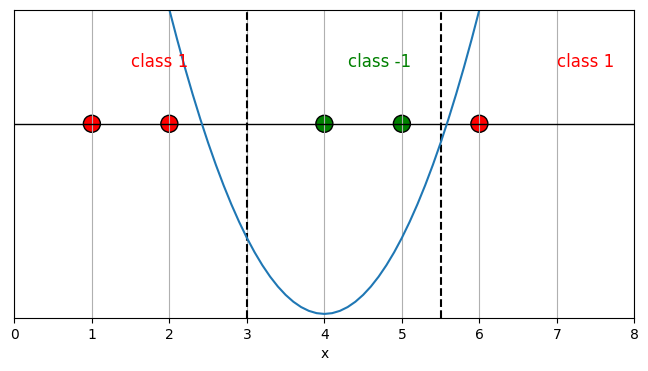

In [5]:
x = np.array([1, 2, 4, 5, 6])
class_labels = np.array([1, 1, 2, 2, 1])
y = class_labels - 3 + 3 *(class_labels == 1)

_, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x, np.zeros_like(x), 
            c=np.where(class_labels == 1, 'red', 'green'), 
            s=150, 
            edgecolors='black', 
            marker='o')

ax.set_ylim(-1.7, 1)
ax.set_xlim(0, 8)
ax.set_xlabel('x')
ax.set_yticks([])

# Add text annotations
ax.text(1.5, 0.5, 'class 1', color='red', fontsize=12)
ax.text(4.3, 0.5, 'class -1', color='green', fontsize=12)
ax.text(7, 0.5, 'class 1', color='red', fontsize=12)

# Add grid
ax.grid(True)

# Add horizontal and vertical lines
ax.axhline(0, color='black', linewidth=1)
ax.axvline(3, color='black', linestyle='--')
ax.axvline(5.5, color='black', linestyle='--')
xT = np.arange(0, 7, 0.1)
ax.plot(xT, w2*xT**2 + w1*xT + w0)
# Show the plot
plt.show()

# Exercice II : Support Vector Machines and cross validation

In this exercise, we study the `checkerboard` simulated data set

**Question 1.** Make a toy example that looks like Figure 2. For that, you can use following script:

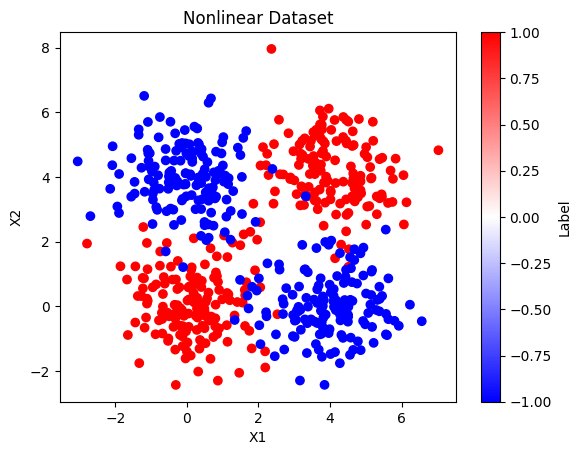

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal

np.random.seed(1)
def generate_dataset_nonlinear(n, p):
    # Generate the bottom-left points
    bottom_left = multivariate_normal(mean=np.zeros(p), cov=np.eye(p), size=n)
    
    # Generate the upper-right points
    upper_right = multivariate_normal(mean=np.full(p, 4), cov=np.eye(p), size=n)
    
    # Generate the upper-left points (adjusted for 2D case)
    upper_left = multivariate_normal(mean=[0, 4], cov=np.eye(p), size=n)
    
    # Generate the bottom-right points (adjusted for 2D case)
    bottom_right = multivariate_normal(mean=[4, 0], cov=np.eye(p), size=n)
    
    # Labels for the classes
    y = np.concatenate([np.ones(2 * n), -np.ones(2 * n)])
    
    # Combine the datasets and create a DataFrame
    x = np.vstack([bottom_left, upper_right, upper_left, bottom_right])
    data = pd.DataFrame(x, columns=[f"X{i+1}" for i in range(p)])
    data['y'] = y
    
    return data

# Generate the dataset
data = generate_dataset_nonlinear(150, 2)

# Plot the data
plt.scatter(data['X1'], data['X2'], c=data['y'], cmap='bwr', label=data['y'])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Nonlinear Dataset')
plt.colorbar(label='Label')
plt.show()

\textbf{Question 2.}  Using the `createDataPartition` function of the `caret` package, create a train/test partition of your `checkerboard` simulated dataset.

In [6]:
from sklearn.model_selection import train_test_split
train_dataset,test_dataset=train_test_split(data,test_size=0.3,random_state=1)

**Question 3.**  From the training set, train a nonlinear SVM combined with gaussian kernel\footnote{We recall that within the \texttt{kernlab} library, gaussian kernel is defined as:
\begin{equation}
k(\mathbf{x}_i, \mathbf{x}_j) = \text{exp}\bigg(- \sigma \Vert \mathbf{x}_i - \mathbf{x}_j \Vert^2\bigg)
\end{equation}
} with $\sigma = 1$ and the regularization parameter $C=1$. 

You can used the \texttt{kernlab:::ksvm()} function.

In [7]:
from sklearn.svm import SVC

C=1
sigma=1
model=SVC(C=C,kernel="rbf",gamma=1/(2*sigma**2))


In [8]:
# train the model
model.fit(X=train_dataset[['X1','X2']],y=train_dataset['y'])

SVC(C=1, gamma=0.5)

**Question 4.** Visualize the resulting SVM model (using `plot.ksvm()`). 

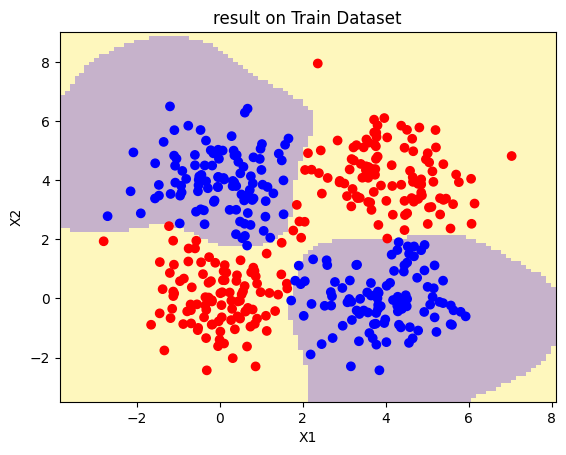

In [9]:
# Plot the data
from sklearn.inspection import DecisionBoundaryDisplay

def plot_dataset(dataset_plot, model, title=""):
    _, ax = plt.subplots()
    common_params = {"estimator": model, "X": dataset_plot[['X1','X2']], "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    ax.scatter(dataset_plot['X1'], dataset_plot['X2'], c=model.predict(dataset_plot[["X1","X2"]]), cmap='bwr', label=model)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_title(title)
    plt.show()
plot_dataset(dataset_plot=train_dataset, model=model, title="result on Train Dataset")

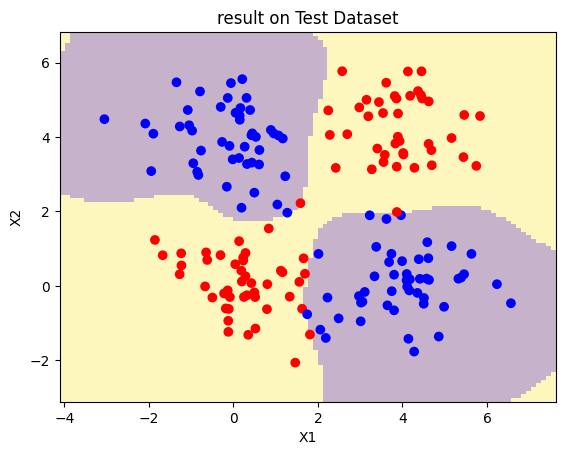

In [10]:
plot_dataset(test_dataset, model=model, title="result on Test Dataset")

**Question 5.** For small value of $\sigma$, we can reduce the exponential function to its first-order Taylor approximation. In this case, prove that the SVM decision boundary is linear.

$k(\mathbf{x}_i, \mathbf{x}_j) = \text{exp}\bigg(- \sigma \Vert \mathbf{x}_i - \mathbf{x}_j \Vert^2\bigg)\simeq 1 - \sigma \Vert \mathbf{x}_i - \mathbf{x}_j \Vert^2$ to the order 1 of the Taylor expansion of $\exp(x)$ when $x\rightarrow 0$.

The boundary expression becomes:
$f(\mathbf{u}) = \mu^T\text{diag}(\mathbf{y})(1-\sigma(\mathbf{u}^T\mathbf{u} -2\mathbf{u}^T\mathbf{x}_i + \mathbf{x}_i^T\mathbf{x}_i))_{1\leq i\leq n} + b^*$.

For $\sigma\ll 1$, $1 - (\sqrt{\sigma}\mathbf{u}^T)(\sqrt{\sigma}\mathbf{u}) \simeq 1 - 2\sqrt{\sigma}\mathbf{u}^T\bm{1}$, thus $f(\mathbf{u}) \simeq \mu^T\text{diag}(\mathbf{y})(1-\sqrt{\sigma}(-2\mathbf{u}^T(\sqrt{\sigma}\mathbf{x}_i + \bm{1}) + \mathbf{x}_i^T\mathbf{x}_i))_{1\leq i\leq n} + b^*$.

We recognize the expression of a linear boundary.

**Question 6.** Show the evolution of the cross-validated error rate as function of $C$ and $\sigma$. Deduce the optimal values $(C^*, \sigma^*)$ for $C$ and $\sigma$.

In [24]:
from sklearn.model_selection import StratifiedKFold

# Use KFold to avoid overfitting on the test_dataset defined earlier

C_int = list(np.logspace(-4, 2, 30))
sigma_int = list(np.logspace(-2, 2, 30))

errs = np.zeros((len(C_int), len(sigma_int)))
skf = StratifiedKFold(n_splits=3)

# Grid search CV done without sklearn methods
for i, c in enumerate(C_int):
    for j, sigma in enumerate(sigma_int):
        model = SVC(C=c, kernel="rbf", gamma=1 / (2 * sigma**2))
        # for each fold we compute the error rate
        for k, (train_index, test_index) in enumerate(
            skf.split(data[["X1", "X2"]], data["y"])
        ):
            Xtrain, ytrain, Xtest, ytest = (
                data.loc[train_index, ["X1", "X2"]],
                data.loc[train_index, "y"],
                data.loc[test_index, ["X1", "X2"]],
                data.loc[test_index, "y"],
            )
            model.fit(X=Xtrain, y=ytrain)
            pred = model.predict(Xtest)
            # we sum the error rates for all folds
            errs[i, j] += sum(pred != ytest.to_numpy()) / len(pred)
errs = pd.DataFrame(errs, index=C_int, columns=sigma_int)

# We get the optimal C*, sigma* for the 3-fold CV
cstar, sigma_star = errs.idxmin().iloc[0], errs.T.idxmin().iloc[0]

In [ ]:
# If need to install seaborn package
!pip install seaborn

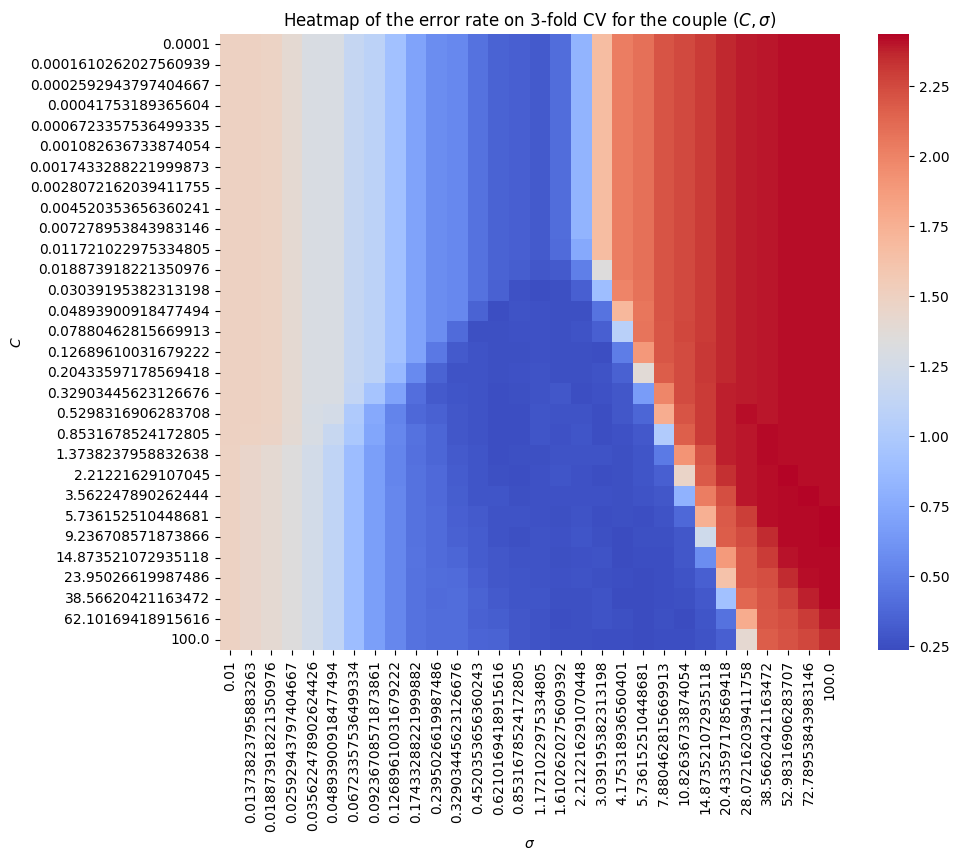

In [25]:
import seaborn as sns
plt.figure(figsize = (10,8))
sns.heatmap(errs, cmap = 'coolwarm')
plt.title("Heatmap of the error rate on 3-fold CV for the couple $(C, \sigma)$")
plt.xlabel("$\sigma$")
plt.ylabel("$C$")
plt.show()

**Question 7.** Build the optimal SVM model and evaluate this model on the test set. Report the test error rate.


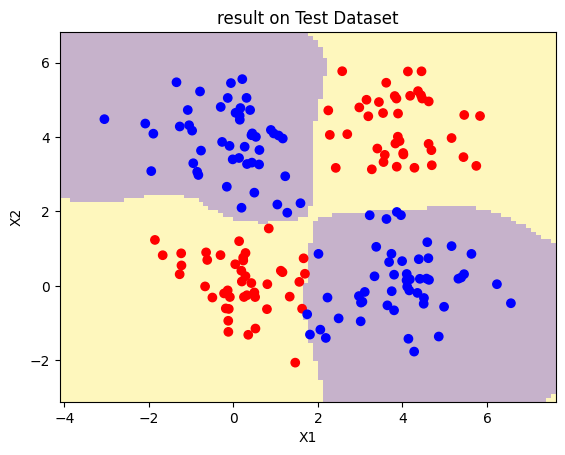

Test error rate: 0.044444444444444446


In [26]:
model = SVC(C=cstar, kernel="rbf", gamma=1 / (2 * sigma_star**2))
model.fit(X=train_dataset[["X1", "X2"]], y=train_dataset["y"])
plot_dataset(test_dataset, model=model, title="result on Test Dataset")


error_rate = sum(model.predict(X=test_dataset[["X1", "X2"]]) != test_dataset["y"].to_numpy()) / len(test_dataset)

#Print the error rate on the test dataset
print(f"Test error rate: {error_rate}")


# Exercice III : Alzheimer or not?

You will find the `Alzheimer` dataset and the associated paper [@webster2009] on Edunao. This dataset contains gene expression measurements for 188 controls versus 176 patients with Alzheimer's disease. The goal is to predict the patient's status based on the expression of 8,650 genes.

\textbf{Question 1.} use linear SVM to predict the patient's status from expression data. In particular, you will have to plot the evolution of the cross-validated classification error rate as a function of the model hyperparameter.

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


alzheimer_df = pd.read_table("./Alzheimer_Webster.txt", header=0, sep=" ")
test_size = 0.3
target = "Y"

In [31]:
C_interval = np.logspace(-10, -1, 50)
fold=5 

In [32]:
from sklearn.model_selection import validation_curve


def fit_C(C, kernel, dataset, target, fold):
    model = SVC(C=C, kernel=kernel)
    train_scores, test_scores = validation_curve(
        estimator=model,
        X=dataset.drop(columns=[target]),
        y=dataset[target],
        param_name="C",
        param_range=C_interval,
        cv=fold,
        n_jobs=-1,
    )

    df = pd.DataFrame()
    df["train_score"] = train_scores.mean(axis=1)
    df["test_score"] = test_scores.mean(axis=1)
    df["C"] = C_interval
    df["Kernel"] = kernel
    return df

Text(0, 0.5, 'Accuracy')

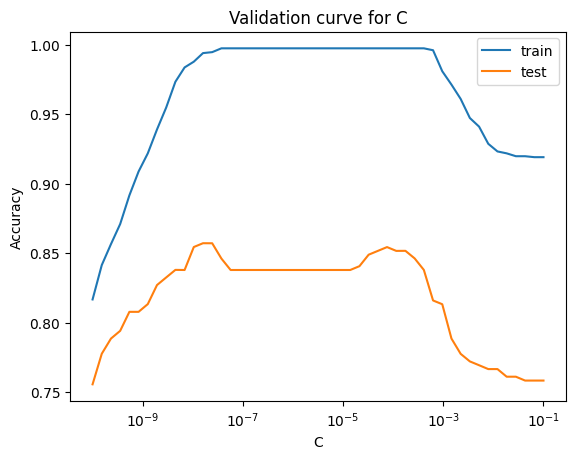

In [34]:
result_df = fit_C(C, "linear", dataset=alzheimer_df, target=target, fold=5)

sns.lineplot(data=result_df, x="C", y="train_score", label="train")
sns.lineplot(data=result_df, x="C", y="test_score", label="test")
plt.xscale("log")
plt.title("Validation curve for C")
plt.ylabel("Accuracy")

In [35]:
max_C_value = result_df[result_df["test_score"]==result_df["test_score"].max()]["C"].values[0]
print("Maximum C value",max_C_value) 
print("Test accuracy",result_df["test_score"].max())

Maximum C value 1.5998587196060573e-08
Test accuracy 0.8570776255707762


**Question 2.** Using the `ConfusionMatrix` function of the `caret` package report the metrics that allow you to quantify the quality of the optimal model. Comment on it.

In [40]:
C=max_C_value
model=SVC(C=C,kernel="linear")
test_size=0.2
dataset=alzheimer_df

In [41]:
train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=1)
model.fit(train_dataset.drop(columns=[target]), train_dataset[target])
y_pred = model.predict(test_dataset.drop(columns=[target]))
accuracy_test = accuracy_score(y_pred, test_dataset[target])

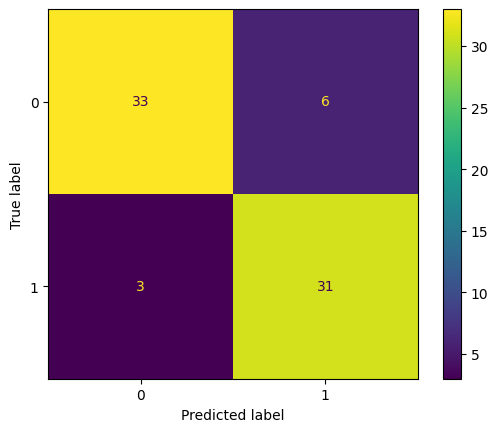

In [42]:
cm=confusion_matrix(y_pred,test_dataset[target])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(test_dataset[target]))
disp.plot()


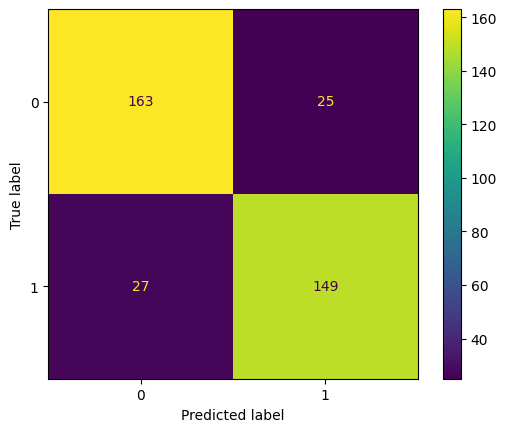

In [43]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model,dataset.drop(columns=[target]),y=dataset[target], cv=5)
cm = confusion_matrix(dataset[target], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_dataset[target]))
disp.plot()

\textbf{Bonus question.} Can you improve the model with more sophisticated kernels?